In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sp-500-stocks/sp500_stocks.csv
/kaggle/input/sp-500-stocks/sp500_companies.csv
/kaggle/input/sp-500-stocks/sp500_index.csv


In [2]:
!pip install pmdarima PyPortfolioOpt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 37.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 31.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 41.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.6/297.6 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 54.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 30.7 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
import lightgbm as lgb
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from pmdarima import auto_arima
from pypfopt import EfficientFrontier, risk_models, expected_returns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
import plotly.graph_objs as go
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [4]:
sp500_companies = pd.read_csv('/kaggle/input/sp-500-stocks/sp500_companies.csv')
sp500_index = pd.read_csv('/kaggle/input/sp-500-stocks/sp500_index.csv')
sp500_stocks = pd.read_csv('/kaggle/input/sp-500-stocks/sp500_stocks.csv')

print(sp500_companies.head())
print(sp500_index.head())
print(sp500_stocks.head())

  Exchange Symbol              Shortname               Longname  \
0      NMS   AAPL             Apple Inc.             Apple Inc.   
1      NMS   NVDA     NVIDIA Corporation     NVIDIA Corporation   
2      NMS   MSFT  Microsoft Corporation  Microsoft Corporation   
3      NMS  GOOGL          Alphabet Inc.          Alphabet Inc.   
4      NMS   GOOG          Alphabet Inc.          Alphabet Inc.   

                   Sector                        Industry  Currentprice  \
0              Technology            Consumer Electronics        221.69   
1              Technology                  Semiconductors        127.72   
2              Technology       Software - Infrastructure        409.54   
3  Communication Services  Internet Content & Information        162.98   
4  Communication Services  Internet Content & Information        164.39   

       Marketcap        Ebitda  Revenuegrowth           City State  \
0  3370596958208  1.317810e+11          0.049      Cupertino    CA   
1  313

**Data Preprocessing**

In [5]:
sp500_index['Date'] = pd.to_datetime(sp500_index['Date'])
sp500_stocks['Date'] = pd.to_datetime(sp500_stocks['Date'])

sp500_index = sp500_index.sort_values('Date')
sp500_stocks = sp500_stocks.sort_values('Date')
sp500_companies.fillna(0, inplace=True)
sp500_stocks.fillna(0, inplace=True)

sp500_index.set_index('Date', inplace=True)

**Exploratory Data Analysis (EDA)**

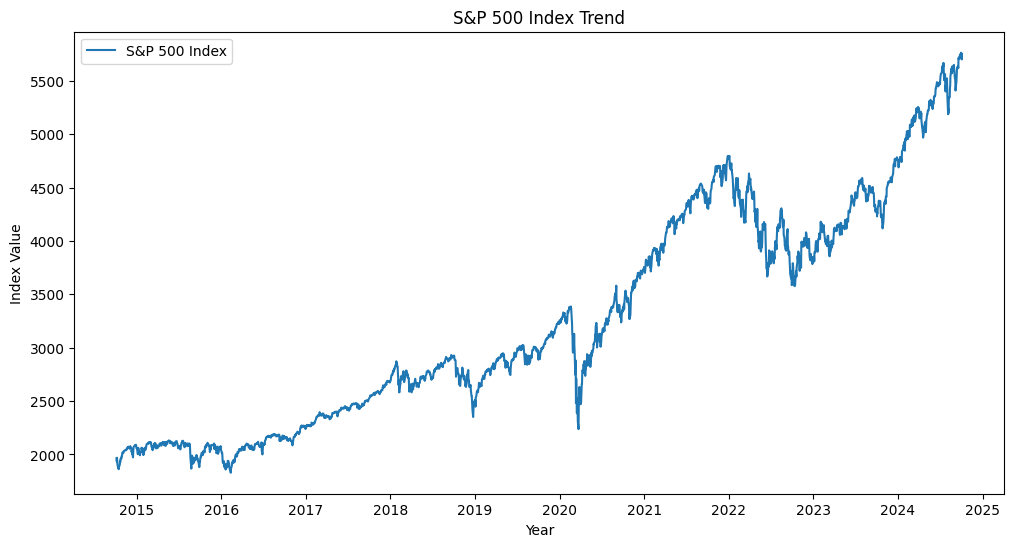

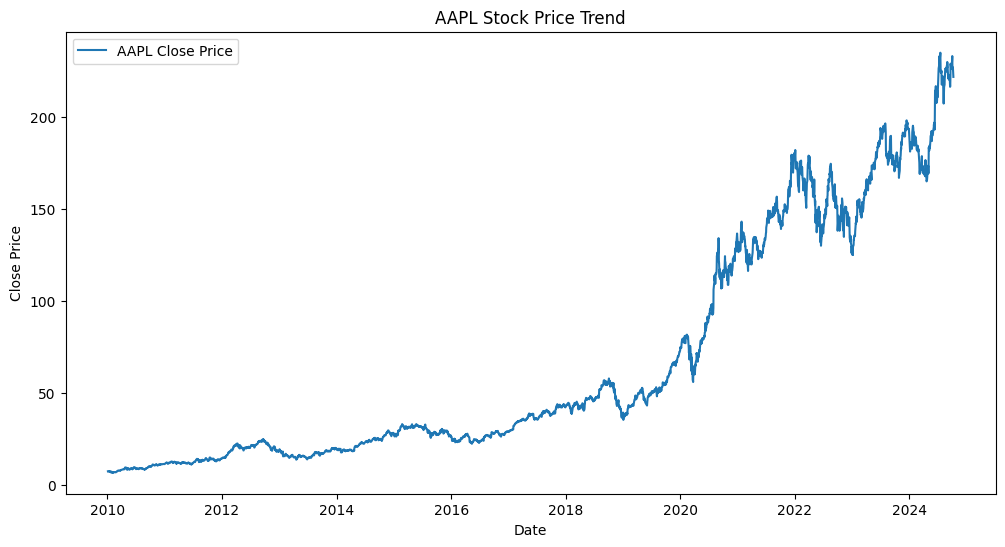

In [6]:
plt.figure(figsize=(12, 6))
plt.plot(sp500_index.index, sp500_index['S&P500'], label="S&P 500 Index")
plt.title("S&P 500 Index Trend")
plt.xlabel('Year')
plt.ylabel('Index Value')
plt.legend()
plt.show()

aapl_stock = sp500_stocks[sp500_stocks['Symbol'] == 'AAPL']
plt.figure(figsize=(12, 6))
plt.plot(aapl_stock['Date'], aapl_stock['Close'], label='AAPL Close Price')
plt.title('AAPL Stock Price Trend')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

**Time Series Forecasting**

> 1. ARIMA Model for S&P 500 Prediction

ADF Statistic: 0.40404464460787926
p-value: 0.9816455680464278
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=25191.473, Time=1.72 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=25280.020, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=25264.109, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=25265.553, Time=0.14 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=25263.433, Time=0.52 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=25263.644, Time=0.32 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=25192.475, Time=2.53 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=25265.898, Time=2.64 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=25262.722, Time=0.25 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=25264.080, Time=3.35 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=25264.559, Time=1.11 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=25195.278, Time=3.51 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=25188.691, Time=4.43 sec
 ARIMA(1,0,2)(0,0,0)[0]

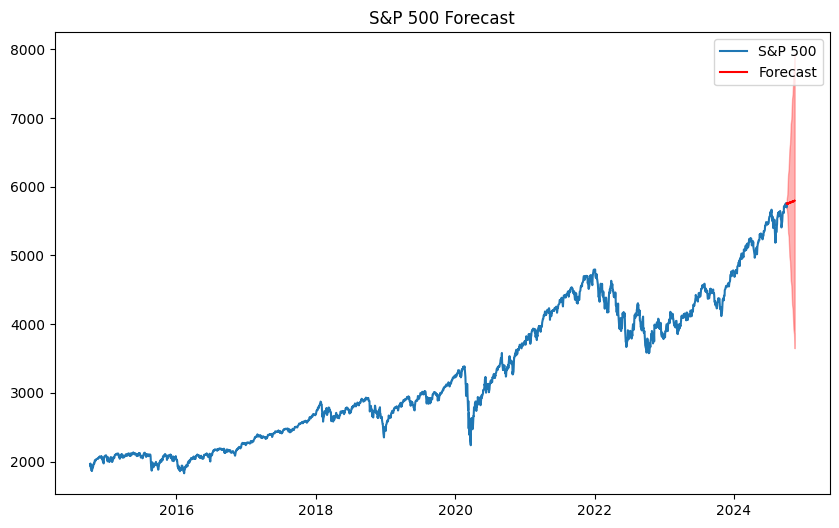

In [7]:
result = sm.tsa.adfuller(sp500_index['S&P500'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

sp500_diff = sp500_index['S&P500'].diff().dropna()

arima_model = auto_arima(sp500_diff, seasonal=False, trace=True, stepwise=True)

n_periods = 30
forecast, conf_int = arima_model.predict(n_periods=n_periods, return_conf_int=True)
forecast_dates = pd.date_range(sp500_index.index[-1], periods=n_periods, freq='B')

plt.figure(figsize=(10,6))
plt.plot(sp500_index.index, sp500_index['S&P500'], label='S&P 500')
plt.plot(forecast_dates, forecast.cumsum() + sp500_index['S&P500'].iloc[-1], label='Forecast', color='red')
plt.fill_between(forecast_dates, conf_int[:, 0].cumsum() + sp500_index['S&P500'].iloc[-1], 
                 conf_int[:, 1].cumsum() + sp500_index['S&P500'].iloc[-1], color='red', alpha=0.3)
plt.title('S&P 500 Forecast')
plt.legend()
plt.show()

> 2. LSTM Model for Stock Price Prediction

Epoch 1/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 11s 86ms/step - loss: 0.0046
Epoch 2/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 7s 81ms/step - loss: 3.5353e-04
Epoch 3/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 8s 84ms/step - loss: 3.1244e-04
Epoch 4/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 7s 81ms/step - loss: 2.5085e-04
Epoch 5/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 8s 84ms/step - loss: 2.7315e-04
Epoch 6/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 7s 79ms/step - loss: 2.4267e-04
Epoch 7/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 7s 81ms/step - loss: 2.0274e-04
Epoch 8/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 11s 84ms/step - loss: 1.9464e-04
Epoch 9/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 8s 83ms/step - loss: 2.5945e-04
Epoch 10/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - loss: 2.1444e-04
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step


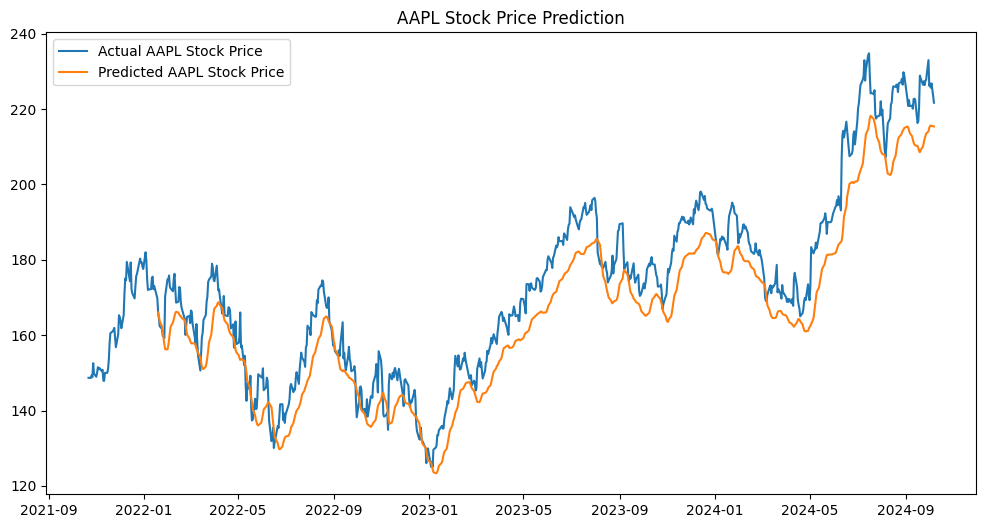

In [8]:
aapl_stock.set_index('Date', inplace=True)
aapl_prices = aapl_stock['Close'].values.reshape(-1,1)

scaler = MinMaxScaler()
aapl_prices_scaled = scaler.fit_transform(aapl_prices)

train_size = int(len(aapl_prices_scaled) * 0.8)
train_data = aapl_prices_scaled[:train_size]
test_data = aapl_prices_scaled[train_size:]

def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data)-seq_length):
        sequences.append(data[i:i+seq_length])
        labels.append(data[i+seq_length])
    return np.array(sequences), np.array(labels)

seq_length = 60
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=100, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X_train, y_train, batch_size=32, epochs=10)

predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

plt.figure(figsize=(12,6))
plt.plot(aapl_stock.index[train_size:], aapl_stock['Close'][train_size:], label='Actual AAPL Stock Price')
plt.plot(aapl_stock.index[train_size+seq_length:], predictions, label='Predicted AAPL Stock Price')
plt.title('AAPL Stock Price Prediction')
plt.legend()
plt.show()

**Portfolio Optimization**

In [9]:
stock_prices = sp500_stocks.pivot(index='Date', columns='Symbol', values='Close').dropna()

mean_returns = expected_returns.mean_historical_return(stock_prices)
cov_matrix = risk_models.sample_cov(stock_prices)

ef = EfficientFrontier(mean_returns, cov_matrix)
weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()

print(cleaned_weights)
ef.portfolio_performance(verbose=True)

OrderedDict([('A', nan), ('AAPL', nan), ('ABBV', nan), ('ABNB', nan), ('ABT', nan), ('ACGL', nan), ('ACN', nan), ('ADBE', nan), ('ADI', nan), ('ADM', nan), ('ADP', nan), ('ADSK', nan), ('AEE', nan), ('AEP', nan), ('AES', nan), ('AFL', nan), ('AIG', nan), ('AIZ', nan), ('AJG', nan), ('AKAM', nan), ('ALB', nan), ('ALGN', nan), ('ALL', nan), ('ALLE', nan), ('AMAT', nan), ('AMCR', nan), ('AMD', nan), ('AME', nan), ('AMGN', nan), ('AMP', nan), ('AMT', nan), ('AMTM', nan), ('AMZN', nan), ('ANET', nan), ('ANSS', nan), ('AON', nan), ('AOS', nan), ('APA', nan), ('APD', nan), ('APH', nan), ('APTV', nan), ('ARE', nan), ('ATO', nan), ('AVB', nan), ('AVGO', nan), ('AVY', nan), ('AWK', nan), ('AXON', nan), ('AXP', nan), ('AZO', nan), ('BA', nan), ('BAC', nan), ('BALL', nan), ('BAX', nan), ('BBY', nan), ('BDX', nan), ('BEN', nan), ('BF-B', nan), ('BG', nan), ('BIIB', nan), ('BK', nan), ('BKNG', nan), ('BKR', nan), ('BLDR', nan), ('BLK', nan), ('BMY', nan), ('BR', nan), ('BRK-B', nan), ('BRO', nan), (

(nan, nan, nan)

**Model Evaluation**

In [10]:
def evaluate_model(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"RMSE: {rmse}, MAE: {mae}, R2: {r2}")

evaluate_model(y_test, predictions)

RMSE: 166.2342998473458, MAE: 164.7777224236294, R2: -2372624.679648233


**Visualization**

In [11]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=sp500_index.index, y=sp500_index['S&P500'], mode='lines', name='S&P 500'))
fig.update_layout(title='S&P 500 Index Over Time', xaxis_title='Date', yaxis_title='Index Value')
fig.show()

aapl_candlestick = aapl_stock[['Open', 'High', 'Low', 'Close']].copy()
aapl_candlestick['Date'] = aapl_stock.index

fig = go.Figure(data=[go.Candlestick(x=aapl_candlestick['Date'],
                                      open=aapl_candlestick['Open'],
                                      high=aapl_candlestick['High'],
                                      low=aapl_candlestick['Low'],
                                      close=aapl_candlestick['Close'])])

fig.update_layout(title='AAPL Stock Candlestick Chart', xaxis_title='Date', yaxis_title='Price')
fig.show()


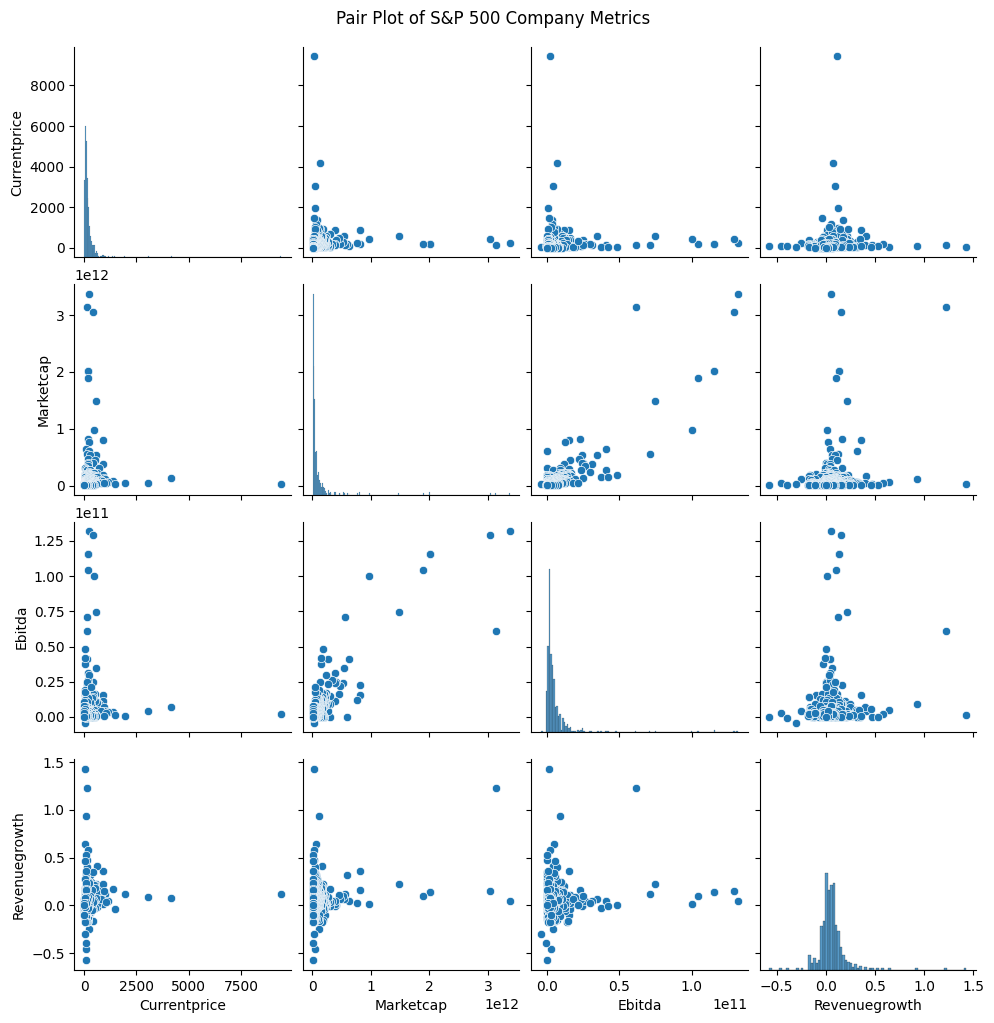

In [12]:
sns.pairplot(sp500_companies[['Currentprice', 'Marketcap', 'Ebitda', 'Revenuegrowth']])
plt.suptitle('Pair Plot of S&P 500 Company Metrics', y=1.02)
plt.show()